In [1]:
from src import *

#for inline visualization in jupyter notebook
%matplotlib inline 

## Description
We extract information from fMRI runs in order to display them on InVesalius.
All related processings are done here.

GOAL: Extracting various informative modalities from fMRI runs

Much help from 
- https://carpentries-incubator.github.io/SDC-BIDS-fMRI/aio/index.html

## Table of Contents
- [Prepocessing of Dataset](#prep)
- [Loading and Visualizing volumes](#loadviz)
- [Generate Network Parcellations](#network)
- [Compute functional connectivity](#fconn)
- [Warpping - Transforming from MNI to Subject Space](#warp)

<a class="anchor" id="prep"></a>
### Preprocessing of dataset

using fmriprep-docker to prep BIDS datasets -> simply run bash scripts on folder with BIDS dataset

- Dataset Download link:
https://openneuro.org/datasets/ds000030/versions/1.0.0

or 

```bash
bash ../../example_fmriprep/ds000102-00001.sh
```

- fmriprep-docker usage:

```bash
fmriprep-docker $bids_root_dir $bids_root_dir/derivatives participant \
        --participant-label $subj \
        --skip-bids-validation \
        --fs-license-file $pathto/license.txt \
        --output-spaces MNI152NLin2009cAsym:res-2 \
        --nthreads $nthreads \
        --stop-on-first-crash \
```


<a class="anchor" id="loadviz"></a>
### Loading and Visualizing volumes

In [3]:
# load from a select session for a single individual
datapath = '../../processed_data/example_frmiprep/derivatives/sub-08/'

struct = nib.load(datapath + 'anat/sub-08_desc-preproc_T1w.nii.gz')
struct_mni = nib.load(datapath + 'anat/sub-08_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz')
mask = nib.load(datapath + 'anat/sub-08_desc-brain_mask.nii.gz')
mask_mni = nib.load(datapath + 'anat/sub-08_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz')
func = nib.load(datapath + 'func/sub-08_task-flanker_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')
mask_func = nib.load(datapath + 'func/sub-08_task-flanker_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz')

T = func.shape[-1]
# Create dummy single frame functional volume 
# Note: arbitrarily take the first slice
sing_func = nib.Nifti1Image(func.get_fdata()[:,:,:,0], func.affine)
# nib.save(sing_func, os.path.join("../resources/", 'sing_func.nii.gz'))

Text(0.5, 1.0, 'fMRI frame masked MNI space')

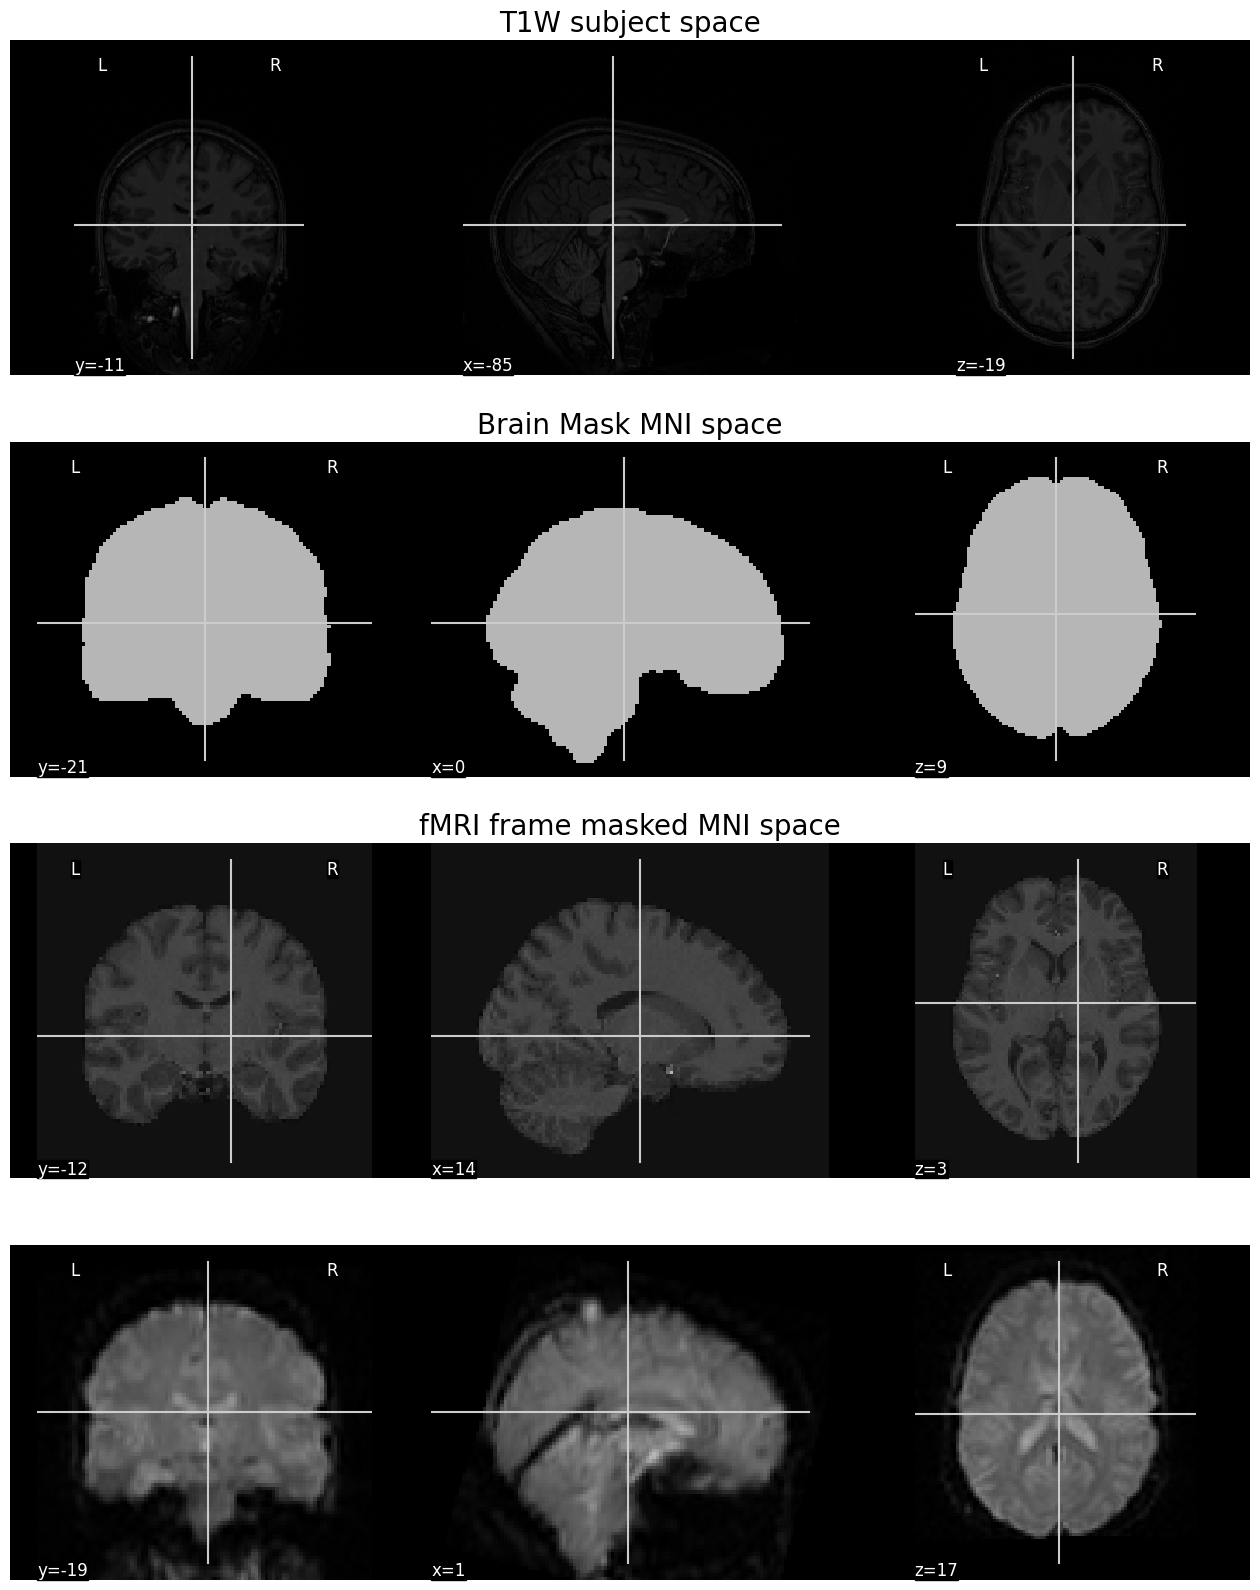

In [4]:
fig, ax = plt.subplots(4,1, figsize=(16,20))
nplot.plot_anat(struct, axes=ax[0])
ax[0].set_title('T1W subject space', fontsize=20)

nplot.plot_anat(mask_mni, axes=ax[1])
ax[1].set_title('Brain Mask MNI space', fontsize=20)

nplot.plot_anat(struct_mni, axes=ax[2])
ax[2].set_title('T1W masked MNI space', fontsize=20)

nplot.plot_anat(sing_func, axes=ax[3])
ax[2].set_title('fMRI frame masked MNI space', fontsize=20)

<a class="anchor" id="network"></a>
### Generate Network Parcellations
We mainly use Yeo7 and Yeo17 as networks that we project back onto fMRI volumes and thus on structural volumes.$

In [7]:
# create yeo volumes parcellation
parcel_dir = '../../resources/rois/'
atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011(parcel_dir)
yeo7 = nib.load(atlas_yeo_2011.thick_7)
yeo17 = nib.load(atlas_yeo_2011.thick_17)
resampled_yeo7 = nimg.resample_to_img(yeo7, func, interpolation = 'nearest')
resampled_yeo17 = nimg.resample_to_img(yeo17, func, interpolation = 'nearest')

nib.save(nib.Nifti1Image(resampled_yeo7.get_fdata()[:,:,:,0], resampled_yeo7.affine),
         '../../resources/yeo7vol.nii.gz')
nib.save(nib.Nifti1Image(resampled_yeo17.get_fdata()[:,:,:,0], resampled_yeo17.affine),
         '../../resources/yeo17vol.nii.gz')

<a class="anchor" id="fconn"></a>
### Compute functional connectivity

In [8]:
# 1. Extract all voxels and respective timecourses
brain_timecourses = manual_flatten(func.get_fdata())

# 2. Select only Gray Matter
gm_mask_func = nib.load(datapath + 'anat/sub-08_space-MNI152NLin2009cAsym_res-2_label-GM_probseg.nii.gz')
gm_timecourses = brain_timecourses[(gm_mask_func.get_fdata() > 0.5).flatten(),:]

print('Total number gray matter voxels: {}'.format(np.sum(gm_mask_func.get_fdata() > 0.5)))

Total number gray matter voxels: 106645


/home/chunhei/miniconda3/envs/invesalius/lib/python3.8/site-packages/nilearn/regions/region_extractor.py:603: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  new_labels_img = new_img_like(labels_img, new_labels_data, affine=affine)


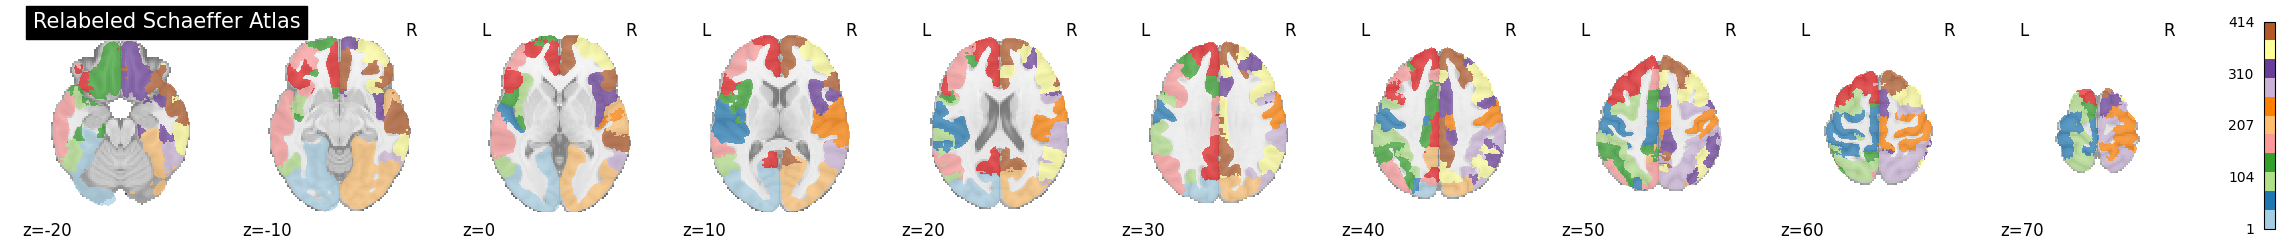

In [9]:
# 3. Select Parcellations that we wish to average from
# we use Schaefer parcellations
n_schf = 414
atlas_schaeffer = datasets.fetch_atlas_schaefer_2018(n_rois=400,data_dir='../../resources/')

region_labels = connected_label_regions(atlas_schaeffer['maps'])

nplot.plot_roi(region_labels,
			cut_coords=(-20,-10,0,10,20,30,40,50,60,70),
			display_mode='z',
			colorbar=True,
			cmap='Paired',
			title='Relabeled Schaeffer Atlas')

resampled_schf = nimg.resample_to_img(region_labels, func, interpolation = 'nearest')

In [16]:
# 4. Region averaging (across parcel groups)
schf_map = resampled_schf.get_fdata()

avg_timecourses = np.zeros((n_schf, T))
for k in range(n_schf):
    avg_timecourses[k,:] = brain_timecourses[(schf_map == k + 1).flatten()].mean(axis=0)

# 5. Compute FC matrix
fc_matrix = FC(np.nan_to_num(avg_timecourses.T))

/tmp/ipykernel_86106/3646382845.py:6: RuntimeWarning: Mean of empty slice.
  avg_timecourses[k,:] = brain_timecourses[(schf_map == k + 1).flatten()].mean(axis=0)
/home/chunhei/miniconda3/envs/invesalius/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/chunhei/miniconda3/envs/invesalius/lib/python3.8/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [


In [17]:
# 6. Compute Functional gradients
g_map  = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
g_map.fit(fc_matrix)

G1 = g_map.gradients_[:,0]

# 7. Project Principal gradients back on volume
schf_gradients_vol = np.zeros_like(schf_map)
x,y,z = resampled_schf.shape
for nx in range(x):
    for ny in range(y):
        for nz in range(z):
            vidx = int(schf_map[nx,ny,nz])
            if vidx == 0: continue
            schf_gradients_vol[nx,ny,nz] = G1[vidx-1]

curmat = deepcopy(np.abs(schf_gradients_vol))
curmat[curmat == 0] = np.nan
# careful it needs to be 'func.affine' here
schf_grads = nib.Nifti1Image(curmat-curmat[~np.isnan(curmat)].min(), func.affine)
nib.save(schf_grads, os.path.join("../../resources/", 'G1_func.nii.gz'))

/home/chunhei/miniconda3/envs/invesalius/lib/python3.8/site-packages/brainspace/gradient/embedding.py:77: UserWarning: Graph is not fully connected.
  warnings.warn('Graph is not fully connected.')


Text(0.5, 1.0, 'Schaeffer Parcellated Principal Gradients')

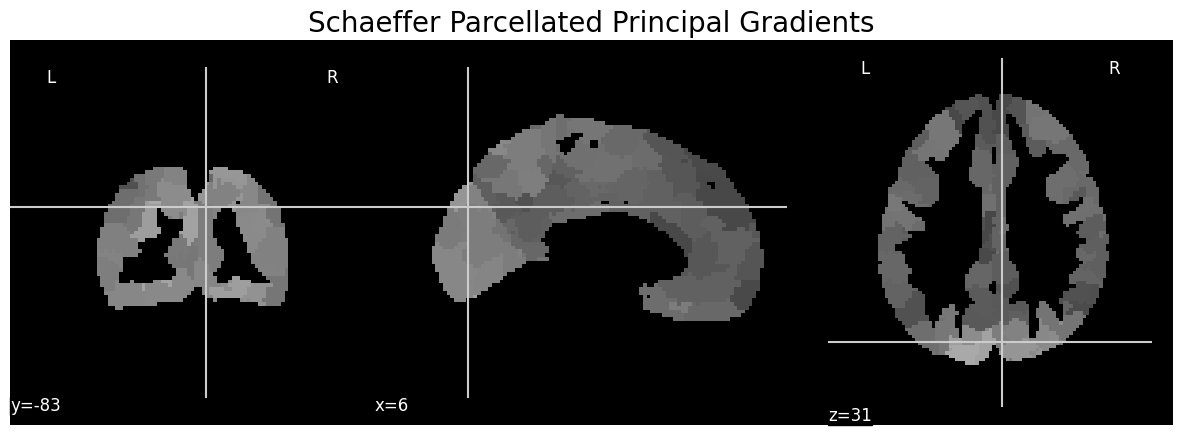

In [21]:
fig, ax = plt.subplots(1, figsize=(15,5))
nplot.plot_anat(schf_grads, axes=ax)
ax.set_title('Schaeffer Parcellated Principal Gradients', fontsize=20)

<a class="anchor" id="warp"></a>
### Warpping - Transforming from MNI to Subject Space
Obtaining the various modalities in MNI space we project them back to subject space following the original transforms when applying registration of T1W to MNI.

Example for warping commands:
```bash
antsApplyTransforms -d 3 --float 1 --verbose 1 -i G1_func.nii.gz -o G1_func_subspace.nii.gz -r sub-08_T1w.nii.gz -t sub-08_transform_MNI_to_T1.h5 -n NearestNeighbor
```

In [10]:
yeo_subspace = nib.load('../../resources/yeo7vol_subspace.nii.gz')
yeo17_subspace = nib.load('../../resources/yeo17vol_subspace.nii.gz')
sing_func_subspace = nib.load('../../resources/sing_func_subj.nii.gz')
G1_func_subspace = nib.load('../../resources/G1_func_subspace.nii.gz')

Text(0.5, 1.0, 'Principal gradients subject space')

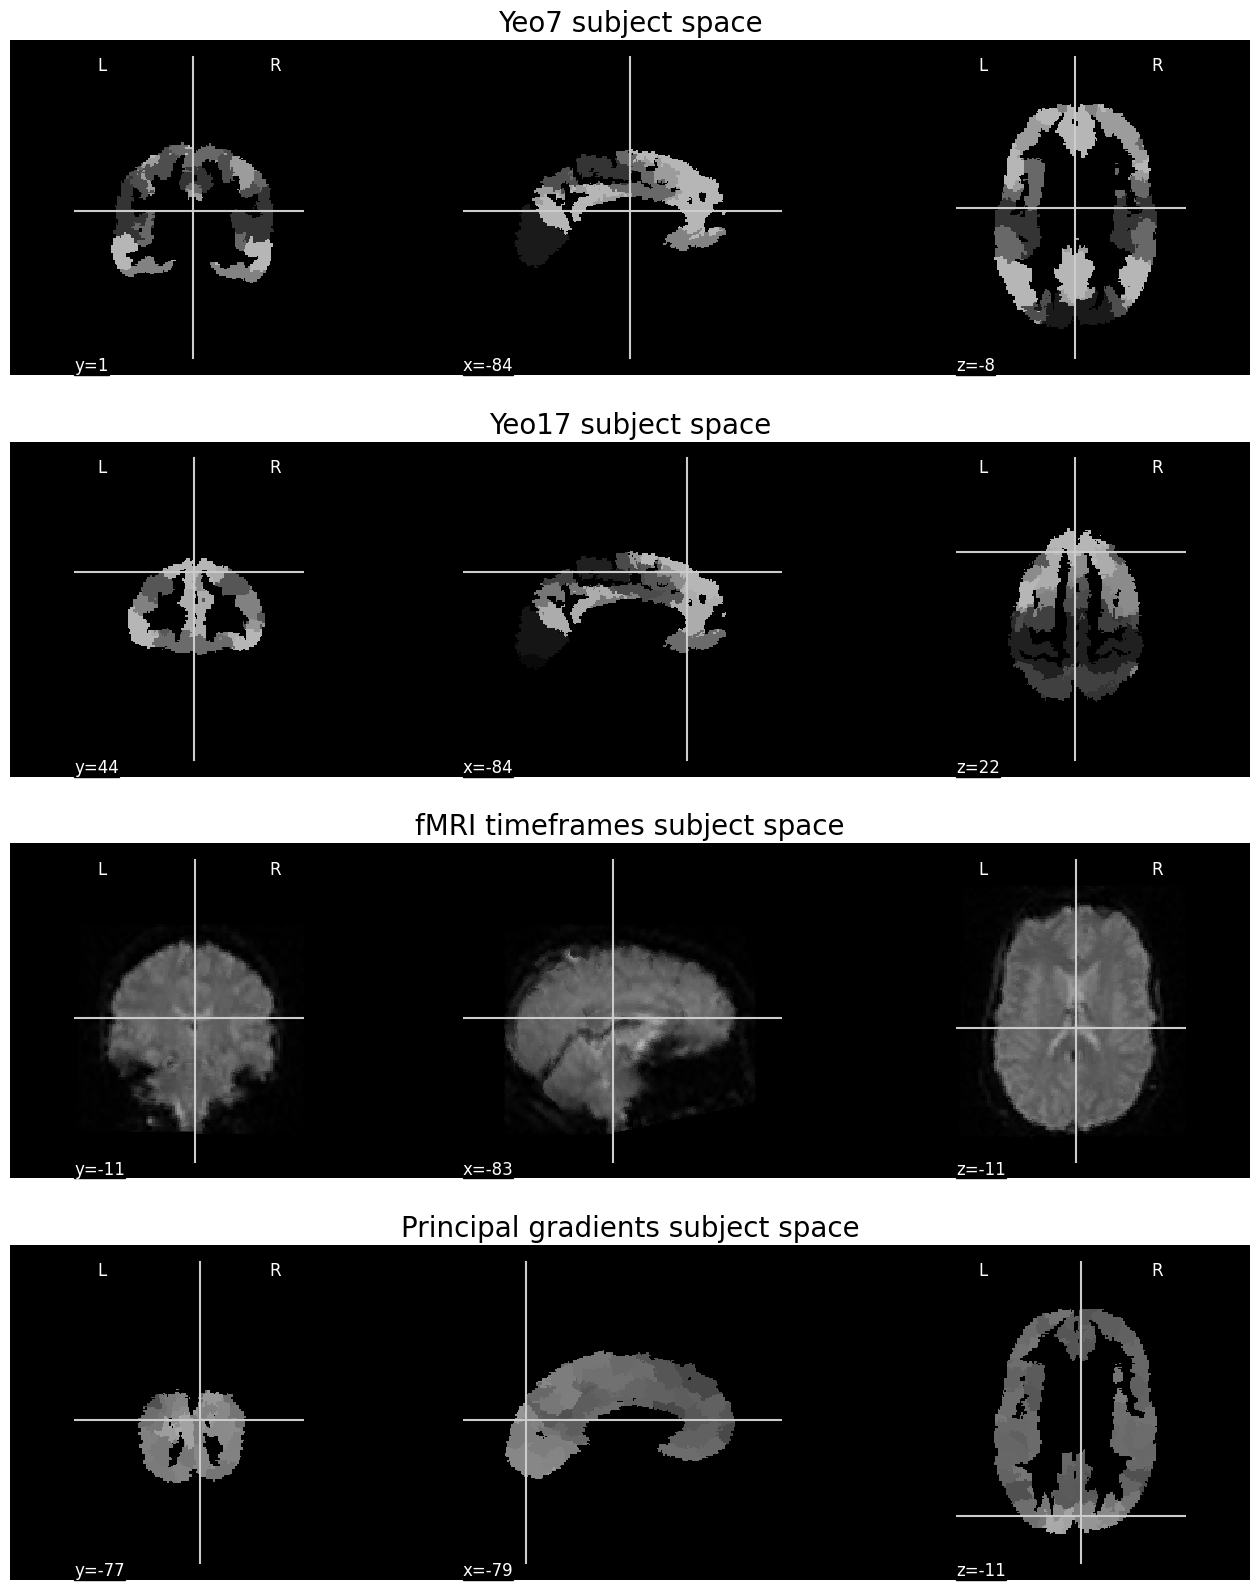

In [20]:
fig, ax = plt.subplots(4,1, figsize=(16,20))
nplot.plot_anat(yeo_subspace, axes=ax[0])
ax[0].set_title('Yeo7 subject space', fontsize=20)

nplot.plot_anat(yeo17_subspace, axes=ax[1])
ax[1].set_title('Yeo17 subject space', fontsize=20)

nplot.plot_anat(sing_func_subspace, axes=ax[2])
ax[2].set_title('fMRI timeframes subject space', fontsize=20)

nplot.plot_anat(G1_func_subspace, axes=ax[3])
ax[3].set_title('Principal gradients subject space', fontsize=20)